<a href="https://colab.research.google.com/github/TranThiDieuHien/DO_AN_1/blob/main/Ph%C3%A2n_t%C3%ADch_d%E1%BB%AF_li%E1%BB%87u.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
#import thư viện
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 50
plt.rcParams.update({'font.size': 18})
import os
import string
from scipy.stats import norm

from wordcloud import WordCloud,STOPWORDS
stopwords = list(STOPWORDS)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score 
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer as CVTZ

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [66]:
def set_seed(seed=31415):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

HOTEL INFORMATION

In [2]:
#doc file
data = pd.read_csv("ThuaThienHue_Infor.csv")

In [ ]:
data.sample(10)

In [9]:
data.columns.values

array(['HAddress', 'HAttractions', 'HGFW', 'HImages', 'HLanguage',
       'HName', 'HPMax', 'HPMin', 'HPRange', 'HQuestions', 'HRImages',
       'HRNumber', 'HRank', 'HRankreview', 'HRating', 'HRestaurants',
       'HReview', 'HRoom', 'HStyles', 'HVideos', 'URL'], dtype=object)

In [8]:
#Tính phần trăm cho từng giá trị trong cột dữ liệu và vẽ biểu đồ trực quan barplot
def stat_table(a, size = (10,15)):
    x = data.groupby(a)[a].count()
    dt = pd.DataFrame(x)
    dt.columns = ['Percent']
    percent = []
    for i in dt['Percent']:
        x = (i/len(data[a]))*100
        percent.append(x)
    dt['Percent'] = percent
    print(dt)
    mylabels = dt.index
    fig = plt.figure(figsize = (5, 10))
    # barplot
    sns.barplot(percent, mylabels, data = dt, orient = 'h')

             Percent
HReview             
Average     6.936416
Excellent  34.393064
Poor        2.601156
Terrible    1.589595
Very good  15.173410


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


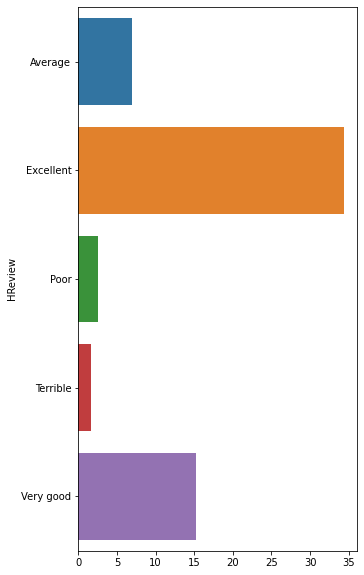

In [10]:
stat_table("HReview")

Ta thấy được rằng số lượng khách sạn được đánh giá là Excellent và Very good là rất cao, chiếm số phần trăm lớn hơn gấp nhiều lần so với Average, Poor và Terrible.

=> Chứng tỏ độ thỏa mãn của khách hàng đối với đa số khách sạn ở Huế là rất cao

=> Khách sạn ở Huế phù hợp để được chọn là nơi nghỉ ngơi khi đi du lịch, công tác tại Huế.


In [ ]:
new_data = data.dropna()
print(new_data)

In [ ]:
#Sap xep lai du lieu theo thu tu
index = []
print(len(new_data))
for i in range (1, len(new_data)+1):
    index.append(i)
new_data["Index"] = index
index1 = new_data.set_index("Index")
new_data = index1.sort_index()
new_data.head(10)

In [ ]:
location = []
atc = new_data["HAttractions"]
gfw = new_data["HGFW"]
rn = new_data["HRestaurants"]
for i in range(1, len(new_data)+1):
    loca = atc[i] + gfw[i] + rn[i]
    location.append(loca)
new_data["Location"] = location
print(new_data[["HName", "Location"]].sample(10))

In [61]:
#Xoa ky tu "&" trong cot
 = new_data["HPMax"].str.replace(r'\D', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Phát biểu giả thuyết
- $$H_{0}: \mu_{0} = \mu_{1}$$
    Giá tiền tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống
- $$H_{1}: \mu_{0} <> \mu_{1}$$
    Giá tiền không tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống

In [63]:
#Su dung thong ke t_test
for i in range(1, len(new_data)+1):
      new_data["HPMax"][i] = int(new_data["HPMax"][i])
      new_data["Location"][i] = int(new_data["Location"][i] )
stat, p_value = stats.ttest_ind(new_data["HPMax"], new_data["Location"])
print('Stat =', stat, 'P_value =', p_value)
if p_value < 0.05:
    print('''Có bằng chứng thống kê để bác bỏ giả thuyết H0. Điều này ngụ ý rằng
          giá tiền khách sạn không tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống gần khách sạn''')
else:
    print('''Chưa có bằng chứng thống kê để bác bỏ giả thuyết H0. Điều này ngụ ý rằng
          giá tiền khách sạn tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống gần khách sạn''')

Stat = -11.474055483278514 P_value = 1.7499803730252178e-22
Có bằng chứng thống kê để bác bỏ giả thuyết H0. Điều này ngụ ý rằng
          giá tiền khách sạn không tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống gần khách sạn


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Nhận xét: Giá tiền khách sạn không tỉ lệ thuận với số lượng địa điểm vui chơi, ăn uống gần khách sạn.

HOTEL REVIEW COMMENTS

In [4]:
#doc file
data_comment = pd.read_csv("ThuaThienHue.csv")

In [ ]:
data_comment.sample(4)

Kiểm tra các giá trị null

In [ ]:
# Kiem tra cac gia tri null
data_comment.isnull().sum()

Làm sạch dữ liệu

In [73]:
import re

def  clean_text(text):
    """
    Lam sach cac du lieu van ban
    * ky hieu
    * doi thanh lower case
    """
    text = text.str.lower()
    text = text.apply(lambda T: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(T))  )
        
    return text

In [70]:
data_comment.columns.values

array(['HComment', 'HCommenter', 'HContribute', 'HDate', 'HThanks',
       'HTime', 'HTravelType', 'HTravelerRating', 'h_Hotel_name',
       'h_reviewer_address', 'h_reviewer_id', 'h_title_comment', 'h_url'],
      dtype=object)

In [74]:
data_comment['HComment']= clean_text(data_comment['HComment'])

In [ ]:
data_comment[["HComment", 'HTravelerRating']].sample(10)

Đếm số lượng từng Rating

In [79]:
data_comment.HTravelerRating.value_counts()

5.0    15218
4.0     4433
3.0     1344
2.0      525
1.0      409
Name: HTravelerRating, dtype: int64

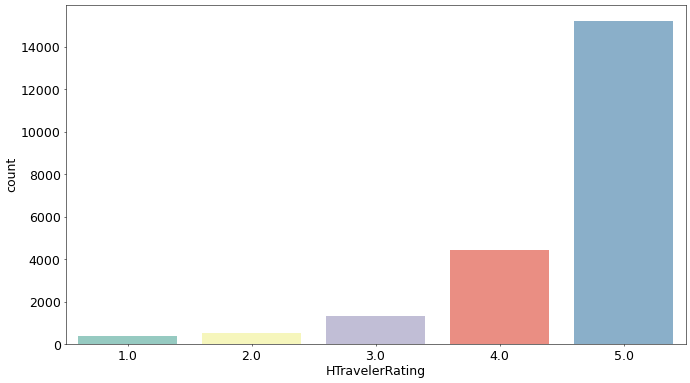

In [80]:
sns.countplot(data=data_comment,x='HTravelerRating', palette="Set3")

Nhận xét: Số lượng rating 5 sao cho các khách sạn ở Huế cao gấp nhiều lần tổng rating 1 đến 4 sao.

=> Điều này có nghĩa rằng các khách sạn ở Huế rất tốt và phù hợp với nhu cầu của khách hàng. 



Ta có thể thấy rõ rằng biến mục tiêu (Rating) không cân bằng, vì có sự khác biệt rất lớn trong rating từ 1 và 5. Vì vậy, ở đây ta sẽ sử dụng một số kỹ thuật lấy mẫu để cân bằng các lớp này.

Lấy số lượng từ trong mỗi bài đánh giá

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


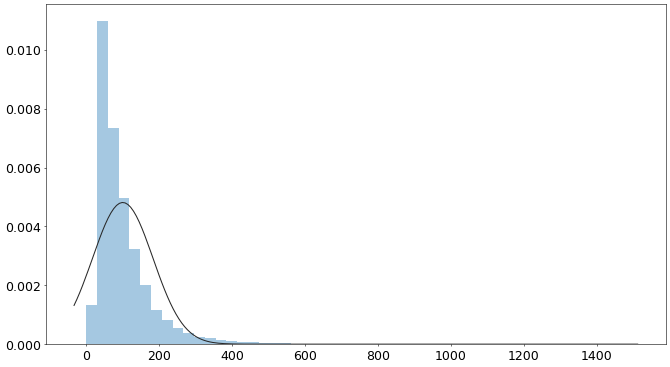

In [81]:
## Lấy số lượng từ bằng cách tách chúng theo dấu cách
words_per_review = [len(x.split(" ")) for x in data_comment['HComment']]
sns.distplot(words_per_review,fit=norm, kde=False)


Wordcloud của các từ phổ biến nhất

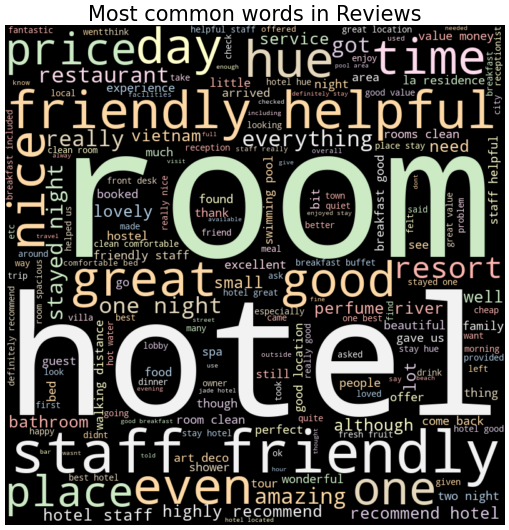

In [82]:
def wordCloud_generator(data_comment):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10,
                          colormap='Pastel1'
                         ).generate(" ".join(data_comment.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("Most common words in Reviews",fontsize=30)
    plt.show() 
    
wordCloud_generator(data_comment['HComment'])

Xử lý trước văn bản


Bây giờ, ta sẽ xử lý trước các comment bằng cách sử dụng một số công cụ NLP như:
1. Chuyển thành lower case
2. Xoá dấu chấm câu
3. Xoá những từ dừng
4. Stemming
5. Bổ sung

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [98]:
punc=string.punctuation

stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

lemmatizer = WordNetLemmatizer()

def data_preprocessing(txt):
    
    #converting to lowercase
    txt=txt.lower()
    
    #Removing Punctuation
    txt="".join([x for x in txt if x not in punc])
    
    #Removing stopwords
    txt=" ".join([word for word in str(txt).split() if word not in stop_words])
    
    #Stemming
    txt = " ".join([stemmer.stem(word) for word in txt.split()])
    
    #Lemmatization
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()])

    return txt

data_comment['text'] = data_comment['HComment'].apply(data_preprocessing)

In [ ]:
data_comment[["HComment", 'HTravelerRating']]

Vectơ hóa văn bản đầu vào

Bây giờ chúng ta sẽ vectơ xếp hạng bằng cách sử dụng điểm TF-IDF và chúng ta sẽ sử dụng toarray () để chuyển đổi ma trận thưa thớt kết quả thành ma trận dày đặc.

In [104]:
### Tạo một đối tượng của class TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=400, min_df=0.05, max_df=0.9)
tfidf = tfidfconverter.fit_transform(data_comment['text']).toarray()

Chia thành các training sets và test sets

In [106]:
X_train,X_test,y_train,y_test = train_test_split(tfidf,data_comment['HTravelerRating'],test_size=0.2,random_state=42)

Lấy mẫu ngược bằng SMOTE

Vì biến mục tiêu của ta không cân bằng, ta sẽ sử dụng thuật toán SMOTE để lấy mẫu thêm cho các lớp thiểu số.

In [108]:
from sklearn.utils import resample
from collections import Counter

print("Trước khi lấy mẫu ngược:-")
print(Counter(y_train))


Trước khi lấy mẫu ngược:-
Counter({5.0: 12144, 4.0: 3561, 3.0: 1078, 2.0: 417, 1.0: 333, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1,

In [112]:
# Su dung SMOTE de lay mau
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("Sau khi lấy mẫu ngược:-")
print(Counter(y_train))

ValueError: ignored

REVIEW HOTEL COMMENTS VIETNAMESE

In [6]:
#doc file
data_comment_viet = pd.read_csv("ThuaThienHue_cmt_Viet.csv")

In [ ]:
data_comment_viet.sample(4)